In [1]:
import pandas as pd
import numpy as np
import json
import category_encoders as ce
import matplotlib.pyplot as plt 
import seaborn as sb
sb.set() 


from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model #linear reg model
from sklearn.model_selection import train_test_split #to split data set into train and test
from sklearn.metrics import mean_squared_error, r2_score #to measure goodness of fit of linear reg
from sklearn.linear_model import LogisticRegression #logistic reg model
from sklearn.metrics import accuracy_score, confusion_matrix #to measure goodness of fit of logistic regression

# Start of data cleaning

### Finding missing rows

In [2]:
# Load JSON data from file
with open('horse_profiles.json', 'r') as f:
    json_data = json.load(f)

# Create DataFrame from JSON data
df = pd.DataFrame(json_data)

filterCols = []
# Iterate over columns and count empty strings in each column
for column in df.columns:
    empty_string_count = (df[column] == "").sum()
    print("Number of empty strings in", column, ":", empty_string_count)
    if(empty_string_count>0):
        filterCols.append(column)
        
print("\nColumns to filter",filterCols)

Number of empty strings in HorseName : 0
Number of empty strings in Barrier : 0
Number of empty strings in CarriedWeight : 5636
Number of empty strings in Distance : 0
Number of empty strings in Placing : 0
Number of empty strings in Rating : 3357
Number of empty strings in HorseWeight : 7762
Number of empty strings in Going : 3
Number of empty strings in Track : 0
Number of empty strings in Jockey : 36
Number of empty strings in Trainer : 2
Number of empty strings in LBW : 54
Number of empty strings in Finish Time : 16222

Columns to filter ['CarriedWeight', 'Rating', 'HorseWeight', 'Going', 'Jockey', 'Trainer', 'LBW', 'Finish Time']


### Filtering out missing rows

In [3]:
#filter out rows of missing data from json

# Create a boolean mask to identify rows with empty strings in multiple columns

# Initialize mask with all True values
mask = pd.Series(True, index=df.index)

# Update mask for each column in filterCols
for col in filterCols:
    mask = mask & (df[col] != "")

# Filter out rows with empty strings from the DataFrame
filtered_df = df[mask]

for column in filtered_df.columns:
    empty_string_count = (filtered_df[column] == "").sum()
    print("Number of empty strings in", column, ":", empty_string_count)
    if(empty_string_count>0):
        filterCols.append(column)

filtered_df

Number of empty strings in HorseName : 0
Number of empty strings in Barrier : 0
Number of empty strings in CarriedWeight : 0
Number of empty strings in Distance : 0
Number of empty strings in Placing : 0
Number of empty strings in Rating : 0
Number of empty strings in HorseWeight : 0
Number of empty strings in Going : 0
Number of empty strings in Track : 0
Number of empty strings in Jockey : 0
Number of empty strings in Trainer : 0
Number of empty strings in LBW : 0
Number of empty strings in Finish Time : 0


,HorseName,Barrier,CarriedWeight,Distance,Placing,Rating,HorseWeight,Going,Track,Jockey,Trainer,LBW,Finish Time
0,A BETTER TOMORROW,4,58.0,1700,2/12,46,476,G,P,R CURATOLO,J PETERS,4.3,1:47.05
1,A BETTER TOMORROW,11,58.0,1600,1/11,42,483,G,T,R CURATOLO,J PETERS,2.0,1:36.23
2,A BETTER TOMORROW,8,55.0,1400,4/10,43,483,G,T,APP S JAMIL,J PETERS,2.3,1:23.08
3,A BETTER TOMORROW,8,55.0,1400,3/12,43,475,G,T,APP S JAMIL,J PETERS,2.0,1:24.39
4,A BETTER TOMORROW,4,57.5,1600,9/10,45,477,G,P,R WOODWORTH,J PETERS,7.6,1:41.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41123,ZYGARDE,5,59.0,1700,5/12,48,520,G,P,M LERNER,KS TAN,5.9,1:46.56
41124,ZYGARDE,2,58.0,1600,5/12,48,526,G,P,S NOH,KS TAN,7.5,1:39.67
41125,ZYGARDE,10,58.5,1200,1/12,43,529,G,P,M LERNER,KS TAN,0.5,1:12.46
41126,ZYGARDE,4,57.5,1200,7/12,45,525,G,P,M LERNER,KS TAN,8.8,1:12.94


## Dealing with numeric cols

### Converting finish times to seconds

In [4]:
# Function to convert mm:ss format to total seconds
def mmss_to_seconds(time_str):
    if isinstance(time_str, str) and ':' in time_str:  # Check if the value is a string and contains the ':' delimiter
        minutes, seconds = map(float, time_str.split(':'))
        return minutes * 60.0 + seconds
    else:
        # Handle cases where the value is not in the expected format
        return None  # Or any other appropriate action

# Apply the function to the FinishingTime column
filtered_df['FinishTime_Seconds'] = filtered_df['Finish Time'].apply(mmss_to_seconds)

C:\Users\aikch\AppData\Local\Temp\ipykernel_19308\3419178251.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['FinishTime_Seconds'] = filtered_df['Finish Time'].apply(mmss_to_seconds)


In [5]:
none_count = filtered_df['FinishTime_Seconds'].value_counts().get(None, 0)
nan_count = filtered_df.isna().sum()
print("Number of NaN occurrences in the column:\n", nan_count)
print("Number of None occurrences in the column:", none_count)

Number of NaN occurrences in the column:
 HorseName             0
Barrier               0
CarriedWeight         0
Distance              0
Placing               0
Rating                0
HorseWeight           0
Going                 0
Track                 0
Jockey                0
Trainer               0
LBW                   0
Finish Time           0
FinishTime_Seconds    1
dtype: int64
Number of None occurrences in the column: 0


In [6]:
# Drop the singular row with Nan FinishTime_Seconds
# First filter any Nan Values
filtered_df.dropna(inplace=True)
nan_count = filtered_df.isna().sum()
print("Number of NaN occurrences in the column:\n", nan_count)

Number of NaN occurrences in the column:
 HorseName             0
Barrier               0
CarriedWeight         0
Distance              0
Placing               0
Rating                0
HorseWeight           0
Going                 0
Track                 0
Jockey                0
Trainer               0
LBW                   0
Finish Time           0
FinishTime_Seconds    0
dtype: int64


C:\Users\aikch\AppData\Local\Temp\ipykernel_19308\4048572157.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.dropna(inplace=True)


### Converting Placing to numeric

In [7]:
# Function to convert mm:ss format to total seconds
def placing(place_str):
    if isinstance(place_str, str) and '/' in place_str:  # Check if the value is a string and contains the ':' delimiter
        place,total = map(int, place_str.split('/'))
        return place
    else:
        # Handle cases where the value is not in the expected format
        return None  # Or any other appropriate action

# Apply the function to the FinishingTime column
filtered_df['Placing_Numeric'] = filtered_df['Placing'].apply(placing)

C:\Users\aikch\AppData\Local\Temp\ipykernel_19308\2666030762.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Placing_Numeric'] = filtered_df['Placing'].apply(placing)


Now, we will need to convert the categorical data into numerical data so that they can be used in our Multiple Linear Regression Model. This is done through Target Encoding for Jockey, Trainer, HorseName. Label Encoding for Going and Track.

### Converting all numeric predictors to float datatype (since they were 'object' datatype from scraping)

In [8]:
numericCols = ['CarriedWeight','Distance','Rating', 'HorseWeight','LBW']

for col in numericCols:
    filtered_df[col] = filtered_df[col].astype(float)

# Confirm the conversion
print(filtered_df['CarriedWeight'].dtype)

float64


C:\Users\aikch\AppData\Local\Temp\ipykernel_19308\3197552711.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[col] = filtered_df[col].astype(float)
C:\Users\aikch\AppData\Local\Temp\ipykernel_19308\3197552711.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[col] = filtered_df[col].astype(float)
C:\Users\aikch\AppData\Local\Temp\ipykernel_19308\3197552711.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

### Label Encoding for Track and Going

In [9]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Going' column to encode categorical labels into numerical labels
filtered_df['encoded_Going'] = label_encoder.fit_transform(filtered_df['Going'])
filtered_df['encoded_Going'] += 1
# Display the mapping between original categorical values and encoded numerical labels
print("'Going' Mapping:")
for original_value, encoded_value in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{original_value}: {encoded_value+1}")

print("'Track' Mapping:")
filtered_df['encoded_Track'] = label_encoder.fit_transform(filtered_df['Track'])
filtered_df['encoded_Track'] += 1

# Display the mapping between original categorical values and encoded numerical labels
print("Mapping between original categorical values and encoded numerical labels:")
for original_value, encoded_value in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{original_value}: {encoded_value+1}")

'Going' Mapping:
F: 1
G: 2
Y: 3
'Track' Mapping:
Mapping between original categorical values and encoded numerical labels:
P: 1
T: 2


C:\Users\aikch\AppData\Local\Temp\ipykernel_19308\798736533.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['encoded_Going'] = label_encoder.fit_transform(filtered_df['Going'])
C:\Users\aikch\AppData\Local\Temp\ipykernel_19308\798736533.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['encoded_Going'] += 1
C:\Users\aikch\AppData\Local\Temp\ipykernel_19308\798736533.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

### Target Encoding for Jockey, Trainer, HorseName

In [21]:
# Initialize the TargetEncoder
target_encoder = ce.TargetEncoder(cols=['Jockey'])

# Fit and transform the DataFrame to perform target encoding
filtered_df['encoded_Jockey'] = target_encoder.fit_transform(filtered_df['Jockey'], filtered_df['LBW'])

# Initialize the TargetEncoder
target_encoder = ce.TargetEncoder(cols=['Trainer'])

# Fit and transform the DataFrame to perform target encoding
filtered_df['encoded_Trainer'] = target_encoder.fit_transform(filtered_df['Trainer'], filtered_df['LBW'])

# Initialize the TargetEncoder
target_encoder = ce.TargetEncoder(cols=['HorseName'])

# Fit and transform the DataFrame to perform target encoding
filtered_df['encoded_HorseName'] = target_encoder.fit_transform(filtered_df['HorseName'], filtered_df['LBW'])

C:\Users\aikch\AppData\Local\Temp\ipykernel_19308\4211158498.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['encoded_Jockey'] = target_encoder.fit_transform(filtered_df['Jockey'], filtered_df['LBW'])
C:\Users\aikch\AppData\Local\Temp\ipykernel_19308\4211158498.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['encoded_Trainer'] = target_encoder.fit_transform(filtered_df['Trainer'], filtered_df['LBW'])
C:\Users\aikch\AppData\Local\Temp\ipykernel_19308\4211158498.py:17: Setting

In [22]:
# Write the encoded values for Jockey to a JSON file
with open('encoded_jockey.json', 'w') as file:
    jockey_json = filtered_df[['Jockey', 'encoded_Jockey']].drop_duplicates().set_index('Jockey')['encoded_Jockey'].to_dict()
    json.dump(jockey_json, file, indent=4)

# Write the encoded values for Trainer to a JSON file
with open('encoded_trainer.json', 'w') as file:
    trainer_json = filtered_df[['Trainer', 'encoded_Trainer']].drop_duplicates().set_index('Trainer')['encoded_Trainer'].to_dict()
    json.dump(trainer_json, file, indent=4)

# Write the encoded values for HorseName to a JSON file
with open('encoded_horse_name.json', 'w') as file:
    horse_json = filtered_df[['HorseName', 'encoded_HorseName']].drop_duplicates().set_index('HorseName')['encoded_HorseName'].to_dict()
    json.dump(horse_json, file, indent=4)

In [12]:
# Display the encoded DataFrame
filtered_df

,HorseName,Barrier,CarriedWeight,Distance,Placing,Rating,HorseWeight,Going,Track,Jockey,Trainer,LBW,Finish Time,FinishTime_Seconds,Placing_Numeric,encoded_Going,encoded_Track,encoded_Jockey,encoded_Trainer,encoded_HorseName
0,A BETTER TOMORROW,4,58.0,1700.0,2/12,46.0,476.0,G,P,R CURATOLO,J PETERS,4.3,1:47.05,107.05,2,2,1,3.592162,4.703901,4.959095
1,A BETTER TOMORROW,11,58.0,1600.0,1/11,42.0,483.0,G,T,R CURATOLO,J PETERS,2.0,1:36.23,96.23,1,2,2,3.592162,4.703901,4.959095
2,A BETTER TOMORROW,8,55.0,1400.0,4/10,43.0,483.0,G,T,APP S JAMIL,J PETERS,2.3,1:23.08,83.08,4,2,2,4.172277,4.703901,4.959095
3,A BETTER TOMORROW,8,55.0,1400.0,3/12,43.0,475.0,G,T,APP S JAMIL,J PETERS,2.0,1:24.39,84.39,3,2,2,4.172277,4.703901,4.959095
4,A BETTER TOMORROW,4,57.5,1600.0,9/10,45.0,477.0,G,P,R WOODWORTH,J PETERS,7.6,1:41.14,101.14,9,2,1,4.779805,4.703901,4.959095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41123,ZYGARDE,5,59.0,1700.0,5/12,48.0,520.0,G,P,M LERNER,KS TAN,5.9,1:46.56,106.56,5,2,1,4.470060,5.552150,4.317815
41124,ZYGARDE,2,58.0,1600.0,5/12,48.0,526.0,G,P,S NOH,KS TAN,7.5,1:39.67,99.67,5,2,1,4.101911,5.552150,4.317815
41125,ZYGARDE,10,58.5,1200.0,1/12,43.0,529.0,G,P,M LERNER,KS TAN,0.5,1:12.46,72.46,1,2,1,4.470060,5.552150,4.317815
41126,ZYGARDE,4,57.5,1200.0,7/12,45.0,525.0,G,P,M LERNER,KS TAN,8.8,1:12.94,72.94,7,2,1,4.470060,5.552150,4.317815


## End of data cleaning

We can now train our MLR Model using the processed data.

In [13]:
#predictors
X = filtered_df[['encoded_HorseName', 'Barrier', 'CarriedWeight', 'Distance', 'Rating', 'HorseWeight', 'encoded_Going', 'encoded_Track', 'encoded_Jockey', 'encoded_Trainer']]

#response
y = filtered_df[['FinishTime_Seconds']] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [14]:
# Make predictions
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

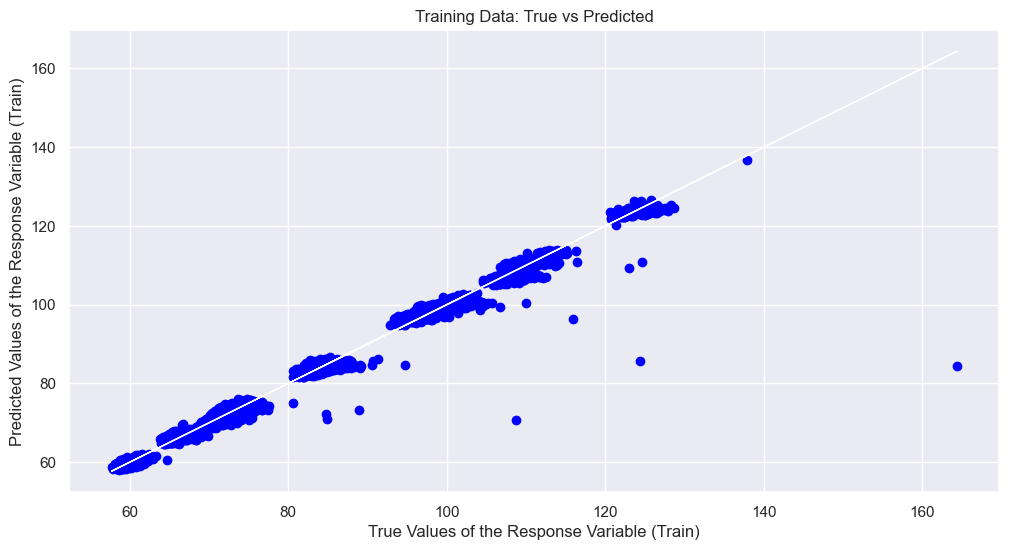

In [15]:
# Plot for training data
plt.figure(figsize=(12, 6))
plt.scatter(y_train, y_train_pred, color="blue")  # Scatter plot of the actual vs predicted
plt.plot(y_train, y_train, 'w-', linewidth=1)  # Line showing the perfect predictions
plt.xlabel("True Values of the Response Variable (Train)")
plt.ylabel("Predicted Values of the Response Variable (Train)")
plt.title("Training Data: True vs Predicted")
plt.show()




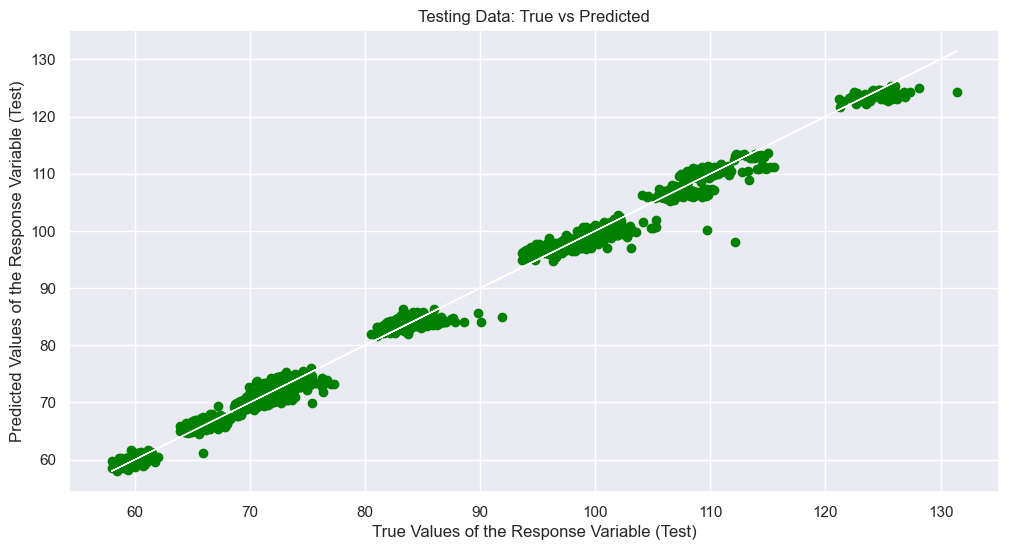

In [16]:
# Plot for testing data
plt.figure(figsize=(12, 6))  # Set the figure size as desired
plt.scatter(y_test, y_test_pred, color="green")  # Scatter plot of the actual vs predicted
plt.plot(y_test, y_test, 'w-', linewidth=1)  # Line showing the perfect predictions
plt.xlabel("True Values of the Response Variable (Test)")
plt.ylabel("Predicted Values of the Response Variable (Test)")
plt.title("Testing Data: True vs Predicted")
plt.show()


## Logistic Regression

we will also attempt to predict the winner of a horse race via assigning a binary value. The horse either wins (1st place) or doesn't win (any other placing)

In [17]:
# First, add a new column into existing dataframe that is encoded win or loss
filtered_df['Top3'] = filtered_df['Placing_Numeric'].isin([1, 2, 3]).astype(int)
filtered_df

C:\Users\aikch\AppData\Local\Temp\ipykernel_19308\2679226817.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Top3'] = filtered_df['Placing_Numeric'].isin([1, 2, 3]).astype(int)


,HorseName,Barrier,CarriedWeight,Distance,Placing,Rating,HorseWeight,Going,Track,Jockey,...,LBW,Finish Time,FinishTime_Seconds,Placing_Numeric,encoded_Going,encoded_Track,encoded_Jockey,encoded_Trainer,encoded_HorseName,Top3
0,A BETTER TOMORROW,4,58.0,1700.0,2/12,46.0,476.0,G,P,R CURATOLO,...,4.3,1:47.05,107.05,2,2,1,3.592162,4.703901,4.959095,1
1,A BETTER TOMORROW,11,58.0,1600.0,1/11,42.0,483.0,G,T,R CURATOLO,...,2.0,1:36.23,96.23,1,2,2,3.592162,4.703901,4.959095,1
2,A BETTER TOMORROW,8,55.0,1400.0,4/10,43.0,483.0,G,T,APP S JAMIL,...,2.3,1:23.08,83.08,4,2,2,4.172277,4.703901,4.959095,0
3,A BETTER TOMORROW,8,55.0,1400.0,3/12,43.0,475.0,G,T,APP S JAMIL,...,2.0,1:24.39,84.39,3,2,2,4.172277,4.703901,4.959095,1
4,A BETTER TOMORROW,4,57.5,1600.0,9/10,45.0,477.0,G,P,R WOODWORTH,...,7.6,1:41.14,101.14,9,2,1,4.779805,4.703901,4.959095,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41123,ZYGARDE,5,59.0,1700.0,5/12,48.0,520.0,G,P,M LERNER,...,5.9,1:46.56,106.56,5,2,1,4.470060,5.552150,4.317815,0
41124,ZYGARDE,2,58.0,1600.0,5/12,48.0,526.0,G,P,S NOH,...,7.5,1:39.67,99.67,5,2,1,4.101911,5.552150,4.317815,0
41125,ZYGARDE,10,58.5,1200.0,1/12,43.0,529.0,G,P,M LERNER,...,0.5,1:12.46,72.46,1,2,1,4.470060,5.552150,4.317815,1
41126,ZYGARDE,4,57.5,1200.0,7/12,45.0,525.0,G,P,M LERNER,...,8.8,1:12.94,72.94,7,2,1,4.470060,5.552150,4.317815,0


In [18]:
#predictors
X = filtered_df[['encoded_HorseName', 'Barrier', 'CarriedWeight', 'Distance', 'Rating', 'HorseWeight', 'encoded_Going', 'encoded_Track', 'encoded_Jockey', 'encoded_Trainer']]

#response
y = filtered_df[['Top3']] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
y_train = np.ravel(y_train)

print("x_train shape :", X_train.shape)
print("y_train shape :", y_train.shape)
print("x_test shape :", X_test.shape)
print("y_test shape :", y_test.shape)

# Initialize and fit logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict on testing set
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

# Calculate accuracy score for training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Calculate accuracy score for testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", test_accuracy)

x_train shape : (11816, 10)
y_train shape : (11816,)
x_test shape : (3939, 10)
y_test shape : (3939, 1)
Training Accuracy: 0.7070920785375762
Testing Accuracy: 0.7090632140137091


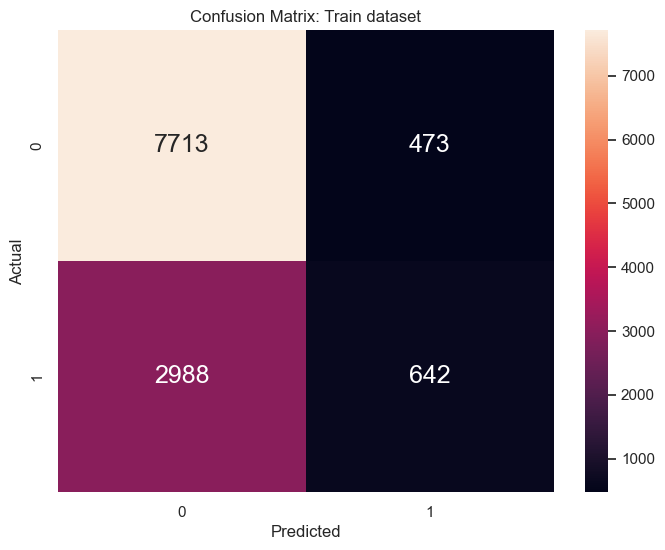

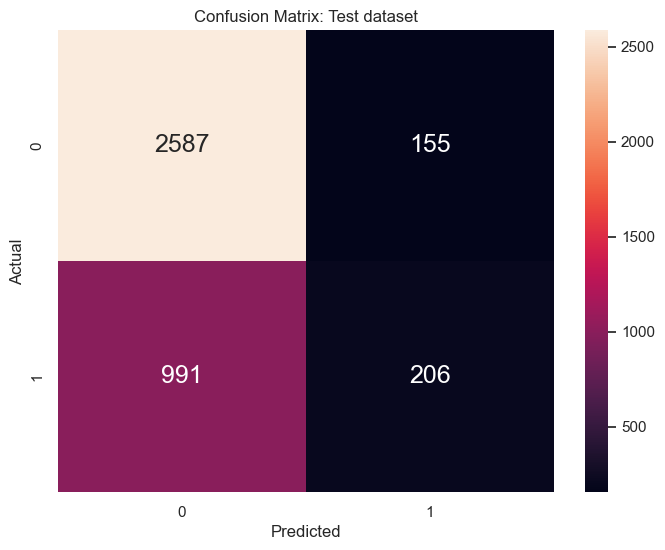

In [19]:
# Plot confusion matrix for Train data set
plt.figure(figsize=(8, 6))
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Train dataset')
plt.show()

# Plot confusion matrix for Train data set
plt.figure(figsize=(8, 6))
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Test dataset')
plt.show()